In [1]:
%matplotlib inline

In [2]:
#Set script to run optimization
run_fit = True

# Importing Libraries

Importing libraries for script

In [3]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.output_points_3d import PointsOutput3D
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi,sin
import sympy
from sympy import sqrt
import math
import logging
import scipy.optimize
import pynamics.integration
import pynamics.system
import numpy.random
import scipy.interpolate
import scipy.optimize
import cma
import pandas as pd
import idealab_tools.units
from matplotlib import animation, rc
from IPython.display import HTML


system = System()
pynamics.set_system(__name__,system)

# Constants of System

In this block of code we are defining all the constants of our system that we will use for our simulation

In [4]:
#seg = segment, t = tail
seg_l = 0.02
t_l = 0.02
seg_h = 0.01
len_factor = 5.5

#Set segment lengths
l = Constant(seg_l,'l',system) #Segment Length, Formula:seg_len
lT = Constant(seg_l,'tail',system) #Tail Length, Formula:tail_len
lP = Constant(seg_l*len_factor,'lP',system) #Constrained length, Forumla:seg_len*constrainted_length_factor

#Set masses, 666.7 is density of laminate structure
m = Constant(666.7*seg_l*seg_h*0.001,'m',system) #Segment Mass, Formula:666.7*seg_len*seg_h*seg_th
mT = Constant(666.7*t_l*seg_h*0.001,'mT',system) #Tail Mass, Formula:666.7*tail_len*seg_h*seg_th

b = Constant(2.148e-6,'b',system)
k = Constant(1.599e-4,'k',system)
rho = Constant(998,'rho',system)
area_p = Constant(seg_l*seg_h,'area_p',system) #area of flat plates
area_f = Constant(seg_h*0.001,'area_f',system)

freq = Constant(1,'freq',system) #frequency of head oscilation
amp = Constant(40*pi/180,'amp',system) #maximum pitch angle of servo 

Ixx = Constant(1/12*(666.7*seg_l*seg_h*0.001)*(seg_h**2 + 0.001**2),'Ixx',system) #Formula: 1/12*666.7*seg_len*seg_h*seg_th*(seg_h**2 + seg_th**2
Iyy = Constant(1/12*(666.7*seg_l*seg_h*0.001)*(seg_h**2 + seg_l**2),'Iyy',system) #Formula: 1/12*(666.7*seg_len*seg_h*seg_th)*(seg_h**2 + seg_len**2)
Izz = Constant(1/12*(666.7*seg_l*seg_h*0.001)*(seg_l**2 + 0.001**2),'Izz',system) #Formula: 1/12*(666.7*seg_len*seg_h*seg_th)*(seg_len**2 + seg_th**2)
Ixx_T = Constant(1/12*(666.7*t_l*seg_h*0.001)*(seg_h*2 + 0.001**2),'Ixx_T',system) #Formula: 1/12*(666.7*tail_len*seg_h*seg_th)*(seg_h*2 + seg_th**2) 
Iyy_T = Constant(1/12*(666.7*t_l*seg_h*0.001)*(seg_h**2 + t_l**2),'Iyy_T',system) #Formula: 1/12*(666.7*tail_len*seg_h*seg_th)*(seg_h**2 + tail_len**2)
Izz_T = Constant(1/12*(666.7*t_l*seg_h*0.001)*(t_l**2 + 0.001**2),'Izz_T',system) #Formula: 1/12*(666.7*tail_len*seg_h*seg_th)*(tail_len**2 + seg_th**2)


In [5]:
#Set integration tolerance
tol = 1e-12

In [6]:
#Set simulation run time
fps = 30
tinitial = 0
tfinal = 2
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [7]:
#Define derivatives of frames
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)
qE,qE_d,qE_dd = Differentiable('qE',system)
qF,qF_d,qF_dd = Differentiable('qF',system)
qT,qT_d,qT_dd = Differentiable('qT',system)

x,x_d,x_dd = Differentiable('x',system)
y,y_d,y_dd = Differentiable('y',system)

In [8]:
#set initial conditions
initialvalues = {}
initialvalues[qA]=40*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=20*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=10*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=0*pi/180
initialvalues[qD_d]=0*pi/180
initialvalues[qE]=-10*pi/180
initialvalues[qE_d]=0*pi/180
initialvalues[qF]=-40*pi/180
initialvalues[qF_d]=0*pi/180
initialvalues[qT]=0*pi/180
initialvalues[qT_d]=0*pi/180

initialvalues[x]=0*pi/180
initialvalues[x_d]=0*pi/180
initialvalues[y]=0*pi/180
initialvalues[y_d]=0*pi/180

statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [9]:
#Frames
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)
D = Frame('D',system)
E = Frame('E',system)
F = Frame('F',system)
T = Frame('T',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(N,[0,0,1],qB,system)
C.rotate_fixed_axis(N,[0,0,1],qC,system)
D.rotate_fixed_axis(N,[0,0,1],qD,system)
E.rotate_fixed_axis(N,[0,0,1],qE,system)
F.rotate_fixed_axis(N,[0,0,1],qF,system)
T.rotate_fixed_axis(N,[0,0,1],qT,system)

# Defining Vectors

In this section of code we are defining all the position and center of mass vecotors. Additionally we are calculating angular velocity of each frame and the respective linear velocities at the center of mass. We also build each body of the system in this section.

In [10]:
#Vectors

pNA=x*N.x + y*N.y + 0*N.z
pP = lP*N.x + pNA
    
pAB= pNA + l*A.x
pBC = pAB + l*B.x
pCD = pBC + l*C.x
pDE = pCD + l*D.x
pEF = pDE + l*E.x
pFT = pEF + l*F.x
pTtip = pFT + lT*T.x

#Center of Mass
pAcm=pNA+l/2*A.x
pBcm=pAB+l/2*B.x
pCcm=pBC+l/2*C.x
pDcm=pCD+l/2*D.x
pEcm=pDE+l/2*E.x
pFcm=pEF+l/2*F.x
pTcm=pFT+lT/2*T.x

#Angular Velocity
wNA = N.get_w_to(A)
wAB = A.get_w_to(B) 
wBC = B.get_w_to(C)
wCD = C.get_w_to(D) 
wDE = D.get_w_to(E)
wEF = E.get_w_to(F)
wFT = F.get_w_to(T)

#Velocities 
vA=pAcm.time_derivative()
vB=pBcm.time_derivative()
vC=pCcm.time_derivative()
vD=pDcm.time_derivative()
vE=pEcm.time_derivative()
vF=pFcm.time_derivative()
vTtip=pTtip.time_derivative()

#Interia and Bodys
IA = Dyadic.build(A,Ixx,Iyy,Izz)
IB = Dyadic.build(B,Ixx,Iyy,Izz)
IC = Dyadic.build(C,Ixx,Iyy,Izz)
ID = Dyadic.build(D,Ixx,Iyy,Izz)
IE = Dyadic.build(E,Ixx,Iyy,Izz)
IF = Dyadic.build(F,Ixx,Iyy,Izz)
IT = Dyadic.build(T,Ixx_T,Iyy_T,Izz_T)

BodyA = Body('BodyA',A,pAcm,m,IA,system)
BodyB = Body('BodyB',B,pBcm,m,IB,system)
BodyC = Body('BodyC',C,pCcm,m,IC,system)
BodyD = Body('BodyD',D,pDcm,m,ID,system)
BodyE = Body('BodyE',E,pEcm,m,IE,system)
BodyF = Body('BodyF',F,pFcm,m,IF,system)
BodyT = Body('BodyT',T,pTcm,mT,IT,system)

# Adding Forces

In this section of code we are adding the aerodynamic, spring, and damping forces in the system. The damping and spring values will be calculated experimentally.

In [11]:
#Forces
#system.addforce(-torque*sympy.sin(freq*2*pi*system.t)*A.z,wNA) #setting motor parameter

#Aerodynamic Forces orthogonal to flat plates
f_aero_Ay = rho * vA.length()*(vA.dot(A.y)) * area_p * A.y
f_aero_By = rho * vB.length()*(vB.dot(B.y)) * area_p * B.y
f_aero_Cy = rho * vC.length()*(vC.dot(C.y)) * area_p * C.y
f_aero_Dy = rho * vD.length()*(vD.dot(D.y)) * area_p * D.y
f_aero_Ey = rho * vE.length()*(vE.dot(E.y)) * area_p * E.y
f_aero_Fy = rho * vF.length()*(vF.dot(F.y)) * area_p * F.y
f_aero_Ty = rho * vTtip.length()*(vTtip.dot(T.y)) * area_p * T.y

system.addforce(-f_aero_Ay,vA)
system.addforce(-f_aero_By,vB)
system.addforce(-f_aero_Cy,vC)
system.addforce(-f_aero_Dy,vD)
system.addforce(-f_aero_Ey,vE)
system.addforce(-f_aero_Fy,vF)
system.addforce(-f_aero_Ty,vTtip)

#Aerodynamic Forces against front of device
f_aero_Ax = rho * vA.length()*(vA.dot(A.x)) * area_f * A.x
system.addforce(-f_aero_Ax,vA)

#Damping Forces
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wCD,wCD)
system.addforce(-b*wDE,wDE)
system.addforce(-b*wEF,wEF)
system.addforce(-b*wFT,wFT)

#Spring Force (Torsion)
system.add_spring_force1(k,(qB-qA)*N.z,wAB)
system.add_spring_force1(k,(qC-qB)*N.z,wBC)
system.add_spring_force1(k,(qD-qC)*N.z,wCD) 
system.add_spring_force1(k,(qE-qD)*N.z,wDE)
system.add_spring_force1(k,(qF-qE)*N.z,wEF)
system.add_spring_force1(k,(qT-qF)*N.z,wFT)

(<pynamics.force.Force at 0x150378186d0>,
 <pynamics.spring.Spring at 0x15037818730>)

# Initial Condition

Solving for initial condition constraints and using scipy to solve for initial states and setting initial states to system initial states.

In [12]:
#Constraints for initial condition

eq = []

eq.append(pFT-pP)
    
eq_scalar = []
eq_scalar.append(eq[0].dot(N.x))
eq_scalar.append(eq[0].dot(N.y))

In [13]:
#Solve for Intial Conditions

qi = [qA,x,y]

qd = [qB,qC,qD,qE,qF,qT]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]
defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]

error = (numpy.array(eq_scalar_c)**2).sum()

f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
    
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

# Setting Dynamic Constraints

Solving for dynamic constraints of system to run simulation.

In [14]:
#Adding Dynamic Constraints

#Position of motor limits
pos = amp*sympy.cos(freq*2*pi*system.t)

eq = []

eq.append(pFT-pP)
eq.append(pos*N.z-qA*A.z)

eq_d = []
eq_d = [item.time_derivative() for item in eq]

eq_dd = []
eq_dd = [item.time_derivative() for item in eq_d]

eq_dd_scalar = []
eq_dd_scalar.append(eq_dd[0].dot(N.x))
eq_dd_scalar.append(eq_dd[0].dot(N.y))
eq_dd_scalar.append(eq_dd[1].dot(N.z))

system.add_constraint(AccelerationConstraint(eq_dd_scalar))

# Solving for Simulation

Code to run simulation and plot motion, states, and total energy in system.

In [15]:
#Solve model and plot angles

#Constraints and Plots

f,ma = system.getdynamics();

tol = 1e-12
points = [pNA,pAB,pBC,pCD,pDE,pEF,pFT,pTtip]

def run_sim(args):
    new_f = args[0] #Set to variables that optimizing
    
    #updating constant values affected by changing optimized values
    new_freq = new_f
    
    #Populate constants with new values, in case for optimizing length and height, all constants get updated
    constants = system.constant_values.copy()
    constants[freq] = new_f
    
    states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':constants},))
    return states

def measured_perf(args):
    print(args)
    try:
        states = run_sim(args)
        linear_disp = abs(states[-1,7])/seg_l #linear displacement relative to segment length, default seg_len = .02
        perf = (1/linear_disp)**2 #desired result is largest propulsion relative to size of device
        return perf
    except scipy.linalg.LinAlgError:
        return 1000


pynamics.system.logger.setLevel(logging.ERROR)

if run_fit:

    func1 = system.state_space_post_invert(f,ma)
    
    guess = [1] #Change depending on what factor you are optimizing 

    pynamics.system.logger.setLevel(logging.ERROR)
    
    sol = scipy.optimize.minimize(measured_perf,guess,bounds=[(0,10)]) #Change bounds depending on optimization parameter
    print(sol.fun)
    result = sol.x

2022-04-26 21:27:16,538 - pynamics.system - INFO - getting dynamic equations
2022-04-26 21:27:38,063 - pynamics.integration - INFO - beginning integration


[1.]


2022-04-26 21:31:01,480 - pynamics.integration - INFO - finished integration
2022-04-26 21:31:01,480 - pynamics.integration - INFO - beginning integration


[1.00000001]


2022-04-26 21:34:19,043 - pynamics.integration - INFO - finished integration
2022-04-26 21:34:19,063 - pynamics.integration - INFO - beginning integration


[1.04380728]


2022-04-26 21:37:30,705 - pynamics.integration - INFO - finished integration
2022-04-26 21:37:30,721 - pynamics.integration - INFO - beginning integration


[1.04380729]


2022-04-26 21:40:43,730 - pynamics.integration - INFO - finished integration
2022-04-26 21:40:43,730 - pynamics.integration - INFO - beginning integration


[1.43063314]


2022-04-26 21:45:04,007 - pynamics.integration - INFO - finished integration
2022-04-26 21:45:04,023 - pynamics.integration - INFO - beginning integration


[1.43063315]


2022-04-26 21:49:25,626 - pynamics.integration - INFO - finished integration
2022-04-26 21:49:25,641 - pynamics.integration - INFO - beginning integration


[1.53568948]


2022-04-26 21:54:20,285 - pynamics.integration - INFO - finished integration
2022-04-26 21:54:20,288 - pynamics.integration - INFO - beginning integration


[1.53568949]


2022-04-26 22:00:05,263 - pynamics.integration - INFO - finished integration
2022-04-26 22:00:05,267 - pynamics.integration - INFO - beginning integration


[2.2837036]


2022-04-26 22:07:21,604 - pynamics.integration - INFO - finished integration
2022-04-26 22:07:21,607 - pynamics.integration - INFO - beginning integration


[2.28370361]


2022-04-26 22:14:52,899 - pynamics.integration - INFO - finished integration
2022-04-26 22:14:52,903 - pynamics.integration - INFO - beginning integration


[1.55046261]


2022-04-26 22:19:35,643 - pynamics.integration - INFO - finished integration
2022-04-26 22:19:35,645 - pynamics.integration - INFO - beginning integration


[1.55046262]


2022-04-26 22:24:20,802 - pynamics.integration - INFO - finished integration
2022-04-26 22:24:20,804 - pynamics.integration - INFO - beginning integration


[2.03440166]


2022-04-26 22:30:21,156 - pynamics.integration - INFO - finished integration
2022-04-26 22:30:21,162 - pynamics.integration - INFO - beginning integration


[2.03440167]


2022-04-26 22:36:12,323 - pynamics.integration - INFO - finished integration
2022-04-26 22:36:12,326 - pynamics.integration - INFO - beginning integration


[2.17285252]


2022-04-26 22:42:21,704 - pynamics.integration - INFO - finished integration
2022-04-26 22:42:21,708 - pynamics.integration - INFO - beginning integration


[2.17285253]


2022-04-26 22:48:30,532 - pynamics.integration - INFO - finished integration
2022-04-26 22:48:30,535 - pynamics.integration - INFO - beginning integration


[2.09026749]


2022-04-26 22:54:17,791 - pynamics.integration - INFO - finished integration
2022-04-26 22:54:17,793 - pynamics.integration - INFO - beginning integration


[2.0902675]


2022-04-26 23:00:01,449 - pynamics.integration - INFO - finished integration
2022-04-26 23:00:01,452 - pynamics.integration - INFO - beginning integration


[2.16347631]


2022-04-26 23:06:09,397 - pynamics.integration - INFO - finished integration
2022-04-26 23:06:09,399 - pynamics.integration - INFO - beginning integration


[2.16347632]


2022-04-26 23:12:17,131 - pynamics.integration - INFO - finished integration
2022-04-26 23:12:17,133 - pynamics.integration - INFO - beginning integration


[2.11820558]


2022-04-26 23:18:16,812 - pynamics.integration - INFO - finished integration
2022-04-26 23:18:16,815 - pynamics.integration - INFO - beginning integration


[2.11820559]


2022-04-26 23:24:08,785 - pynamics.integration - INFO - finished integration
2022-04-26 23:24:08,787 - pynamics.integration - INFO - beginning integration


[2.15830527]


2022-04-26 23:30:16,108 - pynamics.integration - INFO - finished integration
2022-04-26 23:30:16,110 - pynamics.integration - INFO - beginning integration


[2.15830528]


2022-04-26 23:36:29,072 - pynamics.integration - INFO - finished integration
2022-04-26 23:36:29,075 - pynamics.integration - INFO - beginning integration


[2.13334855]


2022-04-26 23:42:33,808 - pynamics.integration - INFO - finished integration
2022-04-26 23:42:33,811 - pynamics.integration - INFO - beginning integration


[2.13334856]


2022-04-26 23:48:39,990 - pynamics.integration - INFO - finished integration
2022-04-26 23:48:39,998 - pynamics.integration - INFO - beginning integration


[2.13389765]


2022-04-26 23:53:31,114 - pynamics.integration - INFO - finished integration
2022-04-26 23:53:31,117 - pynamics.integration - INFO - beginning integration


[2.13389766]


2022-04-26 23:59:40,079 - pynamics.integration - INFO - finished integration
2022-04-26 23:59:40,082 - pynamics.integration - INFO - beginning integration


[2.13609406]


2022-04-27 00:06:38,408 - pynamics.integration - INFO - finished integration
2022-04-27 00:06:38,411 - pynamics.integration - INFO - beginning integration


[2.13609407]


2022-04-27 00:12:47,498 - pynamics.integration - INFO - finished integration
2022-04-27 00:12:47,501 - pynamics.integration - INFO - beginning integration


[2.13452987]


2022-04-27 00:19:21,998 - pynamics.integration - INFO - finished integration
2022-04-27 00:19:22,003 - pynamics.integration - INFO - beginning integration


[2.13452988]


2022-04-27 00:26:07,667 - pynamics.integration - INFO - finished integration
2022-04-27 00:26:07,667 - pynamics.integration - INFO - beginning integration


[2.13403029]


2022-04-27 00:32:09,637 - pynamics.integration - INFO - finished integration
2022-04-27 00:32:09,637 - pynamics.integration - INFO - beginning integration


[2.1340303]


2022-04-27 00:38:09,041 - pynamics.integration - INFO - finished integration
2022-04-27 00:38:09,056 - pynamics.integration - INFO - beginning integration


[2.13203198]


2022-04-27 00:44:07,431 - pynamics.integration - INFO - finished integration
2022-04-27 00:44:07,431 - pynamics.integration - INFO - beginning integration


[2.13203199]


2022-04-27 00:50:04,410 - pynamics.integration - INFO - finished integration
2022-04-27 00:50:04,410 - pynamics.integration - INFO - beginning integration


[2.13359316]


2022-04-27 00:55:57,381 - pynamics.integration - INFO - finished integration
2022-04-27 00:55:57,381 - pynamics.integration - INFO - beginning integration


[2.13359317]


2022-04-27 01:01:43,375 - pynamics.integration - INFO - finished integration
2022-04-27 01:01:43,375 - pynamics.integration - INFO - beginning integration


[2.13394062]


2022-04-27 01:07:33,277 - pynamics.integration - INFO - finished integration
2022-04-27 01:07:33,277 - pynamics.integration - INFO - beginning integration


[2.13394063]


2022-04-27 01:13:29,785 - pynamics.integration - INFO - finished integration
2022-04-27 01:13:29,785 - pynamics.integration - INFO - beginning integration


[2.13401317]


2022-04-27 01:19:27,483 - pynamics.integration - INFO - finished integration
2022-04-27 01:19:27,498 - pynamics.integration - INFO - beginning integration


[2.13401318]


2022-04-27 01:25:24,101 - pynamics.integration - INFO - finished integration
2022-04-27 01:25:24,101 - pynamics.integration - INFO - beginning integration


[2.13403029]


2022-04-27 01:31:23,742 - pynamics.integration - INFO - finished integration
2022-04-27 01:31:23,742 - pynamics.integration - INFO - beginning integration


[2.1340303]


2022-04-27 01:37:21,566 - pynamics.integration - INFO - finished integration
2022-04-27 01:37:21,566 - pynamics.integration - INFO - beginning integration


[2.13180321]


2022-04-27 01:43:20,538 - pynamics.integration - INFO - finished integration
2022-04-27 01:43:20,553 - pynamics.integration - INFO - beginning integration


[2.13180322]


2022-04-27 01:49:18,248 - pynamics.integration - INFO - finished integration
2022-04-27 01:49:18,248 - pynamics.integration - INFO - beginning integration


[2.13369226]


2022-04-27 01:55:17,474 - pynamics.integration - INFO - finished integration
2022-04-27 01:55:17,474 - pynamics.integration - INFO - beginning integration


[2.13369227]


2022-04-27 02:01:12,766 - pynamics.integration - INFO - finished integration
2022-04-27 02:01:12,766 - pynamics.integration - INFO - beginning integration


[2.13392308]


2022-04-27 02:07:08,333 - pynamics.integration - INFO - finished integration
2022-04-27 02:07:08,349 - pynamics.integration - INFO - beginning integration


[2.13392309]


2022-04-27 02:13:04,481 - pynamics.integration - INFO - finished integration
2022-04-27 02:13:04,481 - pynamics.integration - INFO - beginning integration


[2.13399578]


2022-04-27 02:19:05,810 - pynamics.integration - INFO - finished integration
2022-04-27 02:19:05,826 - pynamics.integration - INFO - beginning integration


[2.13399579]


2022-04-27 02:24:59,160 - pynamics.integration - INFO - finished integration
2022-04-27 02:24:59,175 - pynamics.integration - INFO - beginning integration


[2.13401688]


2022-04-27 02:30:49,535 - pynamics.integration - INFO - finished integration
2022-04-27 02:30:49,535 - pynamics.integration - INFO - beginning integration


[2.13401689]


2022-04-27 02:36:47,926 - pynamics.integration - INFO - finished integration
2022-04-27 02:36:47,926 - pynamics.integration - INFO - beginning integration


[2.13402676]


2022-04-27 02:42:40,144 - pynamics.integration - INFO - finished integration
2022-04-27 02:42:40,144 - pynamics.integration - INFO - beginning integration


[2.13402677]


2022-04-27 02:48:28,283 - pynamics.integration - INFO - finished integration
2022-04-27 02:48:28,283 - pynamics.integration - INFO - beginning integration


[2.13402921]


2022-04-27 02:54:25,242 - pynamics.integration - INFO - finished integration
2022-04-27 02:54:25,242 - pynamics.integration - INFO - beginning integration


[2.13402922]


2022-04-27 03:00:24,064 - pynamics.integration - INFO - finished integration
2022-04-27 03:00:24,064 - pynamics.integration - INFO - beginning integration


[2.13402998]


2022-04-27 03:06:17,658 - pynamics.integration - INFO - finished integration
2022-04-27 03:06:17,658 - pynamics.integration - INFO - beginning integration


[2.13402999]


2022-04-27 03:12:14,136 - pynamics.integration - INFO - finished integration
2022-04-27 03:12:14,136 - pynamics.integration - INFO - beginning integration


[2.13403024]


2022-04-27 03:18:09,842 - pynamics.integration - INFO - finished integration
2022-04-27 03:18:09,842 - pynamics.integration - INFO - beginning integration


[2.13403025]


2022-04-27 03:23:59,402 - pynamics.integration - INFO - finished integration
2022-04-27 03:23:59,402 - pynamics.integration - INFO - beginning integration


[2.13403027]


2022-04-27 03:29:46,719 - pynamics.integration - INFO - finished integration
2022-04-27 03:29:46,719 - pynamics.integration - INFO - beginning integration


[2.13403028]


2022-04-27 03:35:44,831 - pynamics.integration - INFO - finished integration
2022-04-27 03:35:44,831 - pynamics.integration - INFO - beginning integration


[2.13403026]


2022-04-27 03:41:37,779 - pynamics.integration - INFO - finished integration
2022-04-27 03:41:37,779 - pynamics.integration - INFO - beginning integration


[2.13403027]


2022-04-27 03:47:33,432 - pynamics.integration - INFO - finished integration


0.0032902224833889445


2022-04-27 03:47:33,589 - pynamics.integration - INFO - beginning integration
2022-04-27 03:53:25,810 - pynamics.integration - INFO - finished integration
2022-04-27 03:53:26,013 - pynamics.output - INFO - calculating outputs
2022-04-27 03:53:26,021 - pynamics.output - INFO - done calculating outputs


[2.13403026]


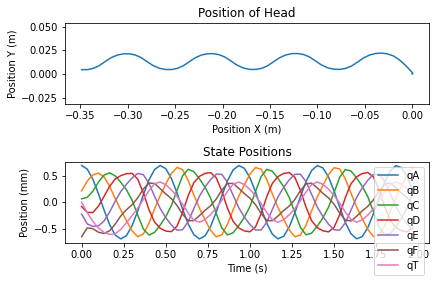

In [16]:
#Constraint Forces
if run_fit:
    states2 = run_sim(result)
    points_output = PointsOutput(points,system)
    y2 = points_output.calc(states2,t)

    fig = plt.figure()
    ax1 = plt.subplot(2,1,2)
    ax1.plot(t,states2[:,:7])
    ax1.legend(['qA','qB','qC','qD','qE','qF','qT'])
    ax1.set_title('State Positions')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position (mm)')

    ax2 = plt.subplot(2,1,1)
    ax2.plot(y2[:,0,0],y2[:,0,1])
    ax2.axis('equal')
    ax2.set_title('Position of Head')
    ax2.set_xlabel('Position X (m)')
    ax2.set_ylabel('Position Y (m)')

    fig.tight_layout()

    print(result)
    
else:
    
    func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)
    states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':system.constant_values},))

    points_output = PointsOutput(points,system) 
    y = points_output.calc(states,t)

    fig = plt.figure(figsize=(8, 6), dpi=80)

    ax1 = plt.subplot(2,1,1)
    ax1.plot(y[:,7,0],y[:,7,1])
    ax1.axis('equal')
    ax1.set_title('Position of Tail Tip')
    ax1.set_xlabel('Position X (m)')
    ax1.set_ylabel('Position Y (m)')

    ax2 = plt.subplot(2,1,2)
    ax2.plot(y[:,0,0],y[:,0,1])
    ax2.axis('equal')
    ax2.set_title('Position of Head')
    ax2.set_xlabel('Position X (m)')
    ax2.set_ylabel('Position Y (m)')
    
    
    fig.tight_layout()
    
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)
    
    points_output = PointsOutput(points,system)
    y = points_output.calc(states,t)
    points_output.plot_time(20)

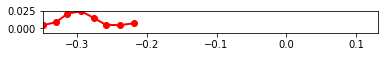

In [17]:
points_output.animate(fps = fps,movie_name = 'dynamics_free_swimming_opt.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
    
HTML(points_output.anim.to_html5_video())

In [19]:
linear_disp_final = abs(states2[-1,7])/seg_l  #relative length of segment
print(linear_disp_final)

17.433611637412202


### Discussion

### Simulation: 
We ran optimization on different constants of the system. I was assigned to optimize the frequency of the cosine wave that is the oscillation frequency. We used scipy.optimize.minimize to optimize the parameters and used the velocity in the x-direction as the performance measure. The performance measure can also be optimized by considering energy of the system that includes the energy used by the motor and the body of the tail. The tail and segment size was optimized based purely on the velocity in the x-direction and thus the displacement can vary with respect to the size of the whole system size.

### Experimental Validation
We manufactured the tail using the optimized parameters and tested it under water. The test results show that the materials used and parameters chosen did not give us the expected results. We believe that the performance measure used while optimizing the parameters should consider not just x-directional velocity but also other factors such as energy used, joint stiffness so that the output would be more close to our expected results.

<img src="https://media.giphy.com/media/QW4wPd85ysxR1jALnX/giphy-downsized-large.gif" width="400" height="400"/>